In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('../data/processed/E_Commerce_Dataset_processed_w_fe.csv')
df.head()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,...,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single,DissatisfactionIndex,DeviceToTenureRatio,InactivityRatio,RecencyWeight,SpendVelocity
0,50001,1,4.0,3,6.0,3.0,3,2,9,1,...,0,0,0,0,1,1.5,0.6,1.0,0.166667,1.833333
1,50002,1,9.0,1,8.0,3.0,4,3,7,1,...,1,0,0,0,1,1.0,0.4,0.0,1.000000,15.000000
2,50003,1,9.0,1,30.0,2.0,4,3,6,1,...,1,0,0,0,1,1.0,0.4,0.3,0.250000,3.500000
3,50004,1,0.0,3,15.0,2.0,4,5,8,0,...,0,0,0,0,1,0.0,4.0,3.0,0.250000,5.750000
4,50005,1,0.0,1,12.0,3.0,3,5,3,0,...,1,0,0,0,1,0.0,3.0,3.0,0.250000,2.750000


## Train–test split and preprocessing consistency
The dataset was split using stratification to preserve the original churn imbalance in both sets.
This avoids distribution drift and prevents the model from learning on an artificially balanced split.

The class ratio was recorded for later use in class-weighted training.

Column names were sanitized again on `X_train` and `X_test` to ensure API-safe, consistent feature names after the split.

In [3]:
X = df.drop(['Churn','CustomerID'], axis=1)
Y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=11, train_size=0.8, test_size=0.2, stratify=Y)

ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

X_train.columns = X_train.columns.str.replace('&', 'and')
X_test.columns = X_test.columns.str.replace('&', 'and')

X_train.columns = X_train.columns.str.replace('-', '_')
X_test.columns = X_test.columns.str.replace('-', '_')

print(X_train.columns.tolist())

['Tenure', 'CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount', 'PreferredLoginDevice_Mobile_Phone', 'PreferredLoginDevice_Phone', 'PreferredPaymentMode_COD', 'PreferredPaymentMode_Cash_on_Delivery', 'PreferredPaymentMode_Credit_Card', 'PreferredPaymentMode_Debit_Card', 'PreferredPaymentMode_E_wallet', 'PreferredPaymentMode_UPI', 'Gender_Male', 'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop_and_Accessory', 'PreferedOrderCat_Mobile', 'PreferedOrderCat_Mobile_Phone', 'PreferedOrderCat_Others', 'MaritalStatus_Married', 'MaritalStatus_Single', 'DissatisfactionIndex', 'DeviceToTenureRatio', 'InactivityRatio', 'RecencyWeight', 'SpendVelocity']


## Model selection and training strategy
Three model families were evaluated: Logistic Regression, Random Forest, and XGBoost.  
All models were configured with imbalance-aware training (class weights or scale_pos_weight) to avoid majority-class collapse.

A unified training pipeline applies standard scaling and SMOTE to construct a balanced synthetic training set,
ensuring that each classifier receives comparable input distributions.

Hyperparameter grids were defined separately for each model to optimize their capacity without overfitting.

In [4]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', random_state=11),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=11),
    "XGBoost": xgb.XGBClassifier(scale_pos_weight=ratio, eval_metric='logloss', random_state=11)
}

params = {
    "Logistic Regression": {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2']
    },
    "Random Forest": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5],
    },
    "XGBoost": {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
    }
}
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=11)),
    ('classifier', LogisticRegression()),
])

In [5]:
results = []
best_estimators = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    pipeline.set_params(classifier=model)
    grid = GridSearchCV(pipeline, params[model_name], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[model_name] = grid.best_estimator_
    
    y_pred = grid.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        'Model': model_name,
        'Best Parameters': grid.best_params_,
        'F1 Score': report['1']['f1-score'],
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'Confusion Matrix': cm
    })
    
    print(f"Completed {model_name}.\n")

Training Logistic Regression...
Completed Logistic Regression.

Training Random Forest...
Completed Random Forest.

Training XGBoost...
Completed XGBoost.



In [6]:
print("\nResults Summary:")
results_df = pd.DataFrame(results)
print(results_df)


Results Summary:
                 Model                                    Best Parameters  \
0  Logistic Regression  {'classifier__C': 10, 'classifier__penalty': '...   
1        Random Forest  {'classifier__max_depth': None, 'classifier__m...   
2              XGBoost  {'classifier__learning_rate': 0.2, 'classifier...   

   F1 Score  Precision    Recall         Confusion Matrix  
0  0.618956   0.489297  0.842105  [[769, 167], [30, 160]]  
1  0.903394   0.896373  0.910526   [[916, 20], [17, 173]]  
2  0.925831   0.900498  0.952632    [[916, 20], [9, 181]]  


C:\Users\bence\AppData\Local\Temp\ipykernel_11256\2021863712.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')


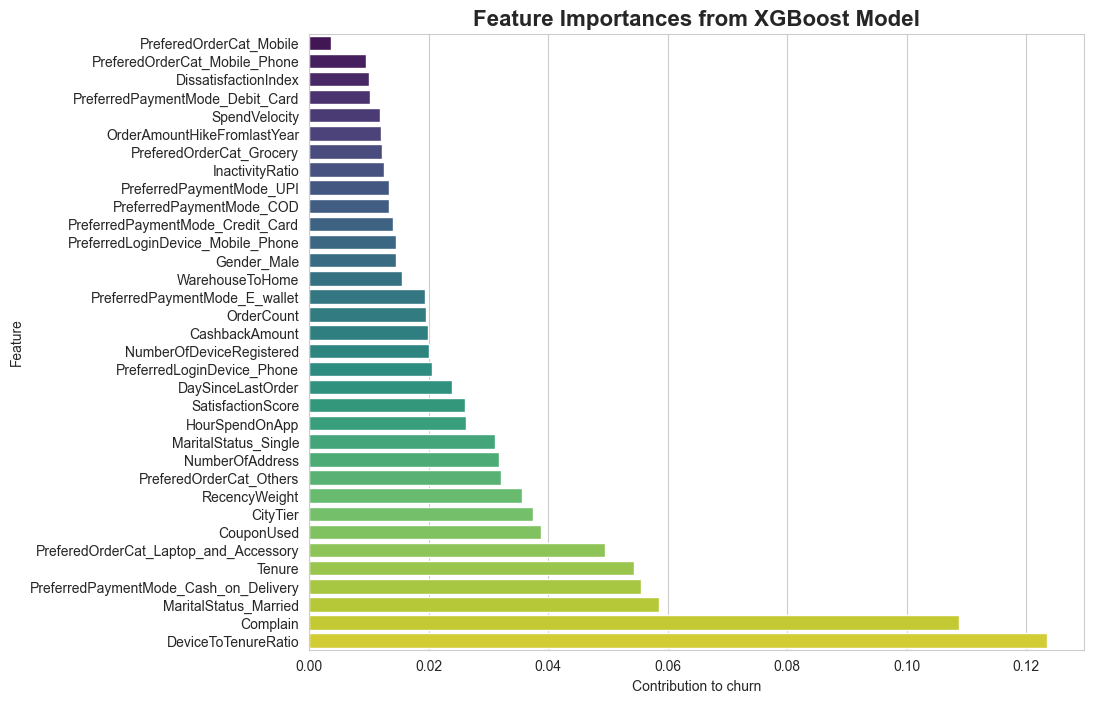

In [7]:
best_pipeline_for_xgb = best_estimators['XGBoost']
xgb_model = best_pipeline_for_xgb.named_steps['classifier']

feature_names = X_train.columns
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.xlabel('Contribution to churn')
plt.title('Feature Importances from XGBoost Model', fontsize=16, weight='bold')
plt.savefig('../visuals/XGBoost_Feature_Importances.png', bbox_inches='tight')
plt.show()
plt.close()


In [8]:
import joblib
joblib.dump(best_estimators['XGBoost'], '../models/best_model_xgboost.pkl')

['../models/best_model_xgboost.pkl']